In [82]:
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt

%matplotlib qt


In [ ]:
#Read a raster
# f = gdal.Open("/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/Mandakini_fullProfileMC_forced_0.2_3_1258909000_10_80_281_for_Arc.csv")
# fA = f.ReadAsArray()

In [69]:
name = "Mandakini_fullProfileMC_forced_0.45_20_2_20_90_281.tree" #Set file name
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Test_data/deeper/" #Set path to data
#for csv files
#data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['id', 'x', 'y', 'chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])
#for tree files
data = np.genfromtxt((path+name), delimiter=' ', skip_header=1, names=['chan_number', 'reciever_chan','node_on_reciever_chan', 'node', 'row','column', 'flow_distance', 'chi', 'elevation', 'drainage_area', 'n_data_points', 'm_mean','m_st_dev', 'm_std_err', 'b_mean', 'b_st_dev', 'b_std_err', 'DW_mean', 'DW_st_dev', 'DW_std_err', 'fitted_elev_mean', 'fitted_elev_stdev', 'fitted_elev_std_err'])






In [89]:
plot_coord(Test)

# plt.imshow(M_HS, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth)
# #plt.scatter(xllcenter, yllcenter)

# plt.show()

In [122]:
def plot_single_channel(data, chan_num):
    plt.figure()
    chan_index = data['chan_number'] == chan_num # 0 = base channel
    chan = data[chan_index] # selects the "True" rows recorded in the boolean index
    flow_distance = chan['flow_distance']
    elevation = chan['elevation']
    plt.plot(flow_distance, elevation, color='b')
    plt.xlabel('Flow Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.show()
    
def plot_single_channel_chi(data, chan_num):
    chan_index = data['chan_number'] == chan_num
    chan = data[chan_index] # selects the "True" rows recorded in the boolean index
    chi = chan['chi']
    elevation = chan['elevation']
    plt.scatter(chi, elevation, c=chi, cmap=plt.get_cmap("jet"))
    plt.xlabel('Chi (X)')
    plt.ylabel('Elevation (m)')
    plt.show()

In [119]:

def plot_all_channels(data):
    plt.figure()

    for i in range(0, len(np.unique(data['chan_number']))):
        chan_index = data['chan_number'] == i
        chan = data[chan_index] # selects the "True" rows recorded in the boolean index
        flow_distance = chan['flow_distance']
        elevation = chan['elevation']
        plt.plot(flow_distance, elevation, color='b')
    plt.xlabel('Flow Distance (m)')
    plt.ylabel('Elevation (m)')
    plt.show()

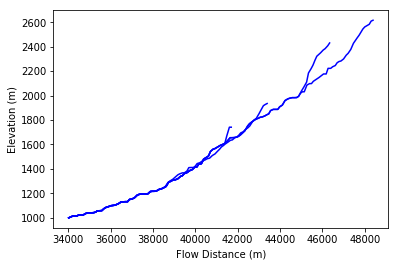

In [115]:
plot_all_channels(data)

In [116]:
def plot_all_channels_chi(data):
    plt.figure()

    for i in range(0, len(np.unique(data['chan_number']))):
        chan_index = data['chan_number'] == i
        chan = data[chan_index] # selects the "True" rows recorded in the boolean index
        chi = chan['chi']
        elevation = chan['elevation']
        plt.scatter(chi, elevation, c=chi, cmap=plt.get_cmap("jet"))
    plt.xlabel('Chi (X)')
    plt.ylabel('Elevation (m)')
    plt.show()

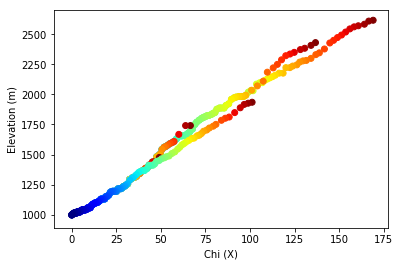

In [117]:
plot_all_channels_chi(data)

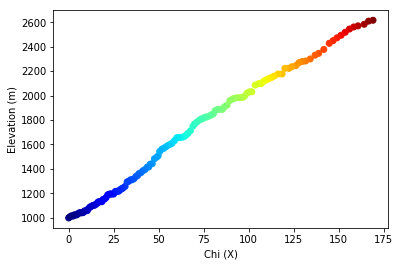

In [124]:
plot_single_channel_chi(data, 0)

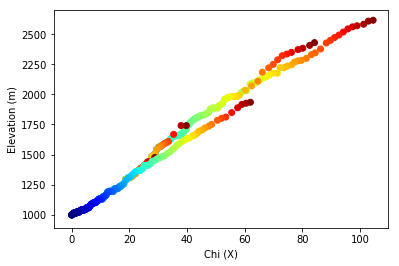

In [104]:
plt.figure()

for i in range(0, len(np.unique(data_05['chan_number']))):
    chan_index = data_05['chan_number'] == i
    chan = data_05[chan_index] # selects the "True" rows recorded in the boolean index
    chi = chan['chi']
    elevation = chan['elevation']
    plt.scatter(chi, elevation, c=chi, cmap=plt.get_cmap("jet"))
plt.xlabel('Chi (X)')
plt.ylabel('Elevation (m)')
plt.show()

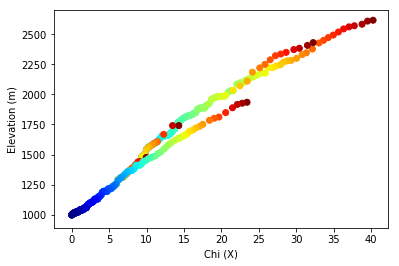

In [110]:
plt.figure()

for i in range(0, len(np.unique(data_06['chan_number']))):
    chan_index = data_06['chan_number'] == i
    chan = data_06[chan_index] # selects the "True" rows recorded in the boolean index
    chi = chan['chi']
    elevation = chan['elevation']
    plt.scatter(chi, elevation, c=chi, cmap=plt.get_cmap("jet"))
plt.xlabel('Chi (X)')
plt.ylabel('Elevation (m)')
plt.show()